In [2]:
import pandas as pd
import numpy as np
import tensorflow
import os
import re
import datetime as dt
import sys
import matplotlib.pyplot as plt

In [2]:
##read csv, change index from numbers to date time. 
#df = pd.read_csv('FarmData.csv')
#df.index = pd.to_datetime(df['Datetime'], format='%Y/%m/%d %H:%M:%S')
##create a copy of data where problem values are set to -1
#graph = df
#graph.loc[graph['Air Temperature (oC) [Site] Quality'] != 'Acceptable', 'Air Temperature (oC) [Site]'] = -1
##trim data down to just Turbidity values
#badData =(df[df['Air Temperature (oC) [Site] Quality'] != 'Acceptable'].index).append(df[df['Soil Temperature @ 15cm Depth (oC) [Catchment 1] Quality'] != 'Acceptable'].index)
#df = df.drop(df[df['Air Temperature (oC) [Site] Quality'] != 'Acceptable'].index)
#df = df.drop(df[df['Soil Temperature @ 15cm Depth (oC) [Catchment 1] Quality'] != 'Acceptable'].index)
#df = df.drop(['Datetime','Air Temperature (oC) [Site] Quality','Air Temperature (oC) [Site] Quality Last Modified'], axis=1)
#df = df.drop(['Soil Temperature @ 15cm Depth (oC) [Catchment 1] Quality','Soil Temperature @ 15cm Depth (oC) [Catchment 1] Quality Last Modified'], axis=1)

In [3]:
#read the downloaded data files
############ USER SPECIFIES FIELDs #####################
farmData = pd.read_csv('Field4.csv')
events = pd.read_csv('Event4.csv')
mySensor = "Soil Temperature @ 15cm Depth (oC) [Catchment 1]"
########################################################

field = mySensor[-3:-1].strip()
window_size = 5
#tidy events
events = events.drop(['Time_in_field','Field','Tractor','Operator','Start_tractor_hours','End_tractor_hours','Total_tractor_hours','Application','Total_application_in_Units','Units','Application_Info','Application_rate_per_ha','Application_batch_nr','Product_Name','Manufacturer'], axis=1)


In [4]:
#Remove bad data so the model only learns from good data
def Qual_Trim(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y/%m/%d %H:%M:%S')
    sensors = []
    for column in df.columns:
        if column.endswith("]"):
            sensors.append(column)
        
    for sensor in sensors:
        df = df.drop(df[df[sensor + ' Quality'] != 'Acceptable'].index)
        df = df.drop([sensor + ' Quality', sensor + ' Quality Last Modified'], axis=1)
    return(df)

#remove any columns that arent sensor data, also make a list of what sensors there are
def Col_Trim(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y/%m/%d %H:%M:%S')
    sensors = []
    for column in df.columns:
        if column.endswith("]"):
            sensors.append(column)
        
    for sensor in sensors:
        df = df.drop([sensor + ' Quality', sensor + ' Quality Last Modified'], axis=1)
    return(df)

#add a seconds time stamp, this is used for the cos and sin waves later
def Stamp_Seconds(df):
    df['Seconds'] = df['Datetime'].map(pd.Timestamp.timestamp)
    df['Datetime'] = df['Datetime'].dt.strftime('%Y/%m/%d %H:%M:%S')
    return(df)

#create the two
traindf = Qual_Trim(farmData)
predictdf = Col_Trim(farmData)
traindf = Stamp_Seconds(traindf)
predictdf = Stamp_Seconds(predictdf)

In [5]:
#merge the sensor data and the event data
def Merge(df,events):
    for a in range(len(events)):
        try:
            date = pd.to_datetime(events.loc[a,'Event_Date'], format='%d/%m/%Y')
            timeIn = pd.to_datetime((events.loc[a,'Event_Date'] + ' ' + events.loc[a,'Time_IN']), format='%d/%m/%Y %H:%M')#.strftime('%Y/%m/%d %H:%M:%S')
            timeOut = pd.to_datetime((events.loc[a,'Event_Date'] + ' ' + events.loc[a,'Time_Out']), format='%d/%m/%Y %H:%M')#.strftime('%Y/%m/%d %H:%M:%S')
            event = events.loc[a,'Field_Operation']
    
            try:
                df[event].values[0]
            except:
                df[event] = 0        
            for b in df['Datetime']:
                if pd.notna(b):
                    time = pd.to_datetime(b, format='%Y/%m/%d %H:%M:%S')
                    if (time >= timeIn and time <= timeOut):
                        print(time.strftime('%Y/%m/%d %H:%M:%S'), event)
                        for n in range(0, 10):
                            df['Datetime'] = df['Datetime'].shift(n)
                            df.loc[df['Datetime'] == time.strftime('%Y/%m/%d %H:%M:%S'),[event]] = round(1-(n/10),1)
                            df['Datetime'] = df['Datetime'].shift(-n)
                else:
                    print('EOF')
                    break
        except:
            print('Bad event data')
Merge(traindf,events)
Merge(predictdf, events)

2018/09/12 11:45:00 Mow
2018/09/12 12:00:00 Mow
2018/09/12 12:15:00 Mow
2018/09/12 12:30:00 Mow
2018/09/12 12:45:00 Mow
2018/09/12 13:00:00 Mow
2018/09/12 13:15:00 Mow
EOF
2018/09/12 14:45:00 Spreading grass
2018/09/12 15:00:00 Spreading grass
2018/09/12 15:15:00 Spreading grass
2018/09/12 15:30:00 Spreading grass
EOF
2018/09/12 15:45:00 Spreading grass
2018/09/12 16:00:00 Spreading grass
EOF
2018/09/13 14:45:00 Rowing up
2018/09/13 15:00:00 Rowing up
2018/09/13 15:15:00 Rowing up
EOF
2018/09/13 15:15:00 Rowing up
2018/09/13 15:30:00 Rowing up
2018/09/13 15:45:00 Rowing up
2018/09/13 16:00:00 Rowing up
2018/09/13 16:15:00 Rowing up
2018/09/13 16:30:00 Rowing up
EOF
2018/09/13 17:30:00 Round baling
2018/09/13 17:45:00 Round baling
2018/09/13 18:00:00 Round baling
2018/09/13 18:15:00 Round baling
2018/09/13 18:30:00 Round baling
2018/09/13 18:45:00 Round baling
EOF
2018/09/13 19:00:00 Round baling
2018/09/13 19:15:00 Round baling
EOF
2018/09/20 09:00:00 Spread Organic Manure
2018/09/20 0

In [6]:
traindf.to_csv('test.csv', sep=',', encoding='utf-8',index=False)

In [7]:
#create sin and cos waves so the model 'understands' how time of day/ time of year affects
def Sin_Cos(df):
    #seconds in a
    day = 60*60*24
    year = day*365.2425

    df['Day sin'] = np.sin(df['Seconds'] * (2 * np.pi / day))
    df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
    df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
    df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
    df = df.drop(['Seconds'], axis=1)
    df = df.drop(['Datetime'], axis=1)
    
    return(df)

traindf = Sin_Cos(traindf)
predictdf = Sin_Cos(predictdf)

In [8]:
#function to convert our data to features and labels
def df_to_X_y(df, window_size, mySensor):#window size is how far we look back to predict next point
    df_as_np = df.to_numpy()
    X = []
    y = []
    try:
        myColumn = df.columns.get_loc(mySensor)
    except:
        print('no column')
    for i in range(len(df_as_np)-window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][myColumn]
        y.append(label)
    return np.array(X), np.array(y)


In [9]:
#call function and print shape to check
X,y = df_to_X_y(traindf, window_size, mySensor)
inputsize = X.shape[1:]
outputsize = y.shape[1:]

In [10]:
#set some values to split the data 
trainSplit = round(X.shape[0]*0.8)
valSplit = round(X.shape[0]*0.85)
X_train, y_train = X[:trainSplit], y[:trainSplit]
X_val, y_val = X[trainSplit:valSplit], y[trainSplit:valSplit]
X_test, y_test = X[valSplit:], y[valSplit:]

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
#set arguments for training model
model1 = Sequential()
model1.add(InputLayer((inputsize)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                21248     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 21,777
Trainable params: 21,777
Non-trainable params: 0
_________________________________________________________________


In [12]:
#create checkpoints incase current model isnt as accurate as previous epoch
cp = ModelCheckpoint(mySensor, save_best_only = True)
model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate=0.000025) , metrics = [RootMeanSquaredError()])

In [13]:
# train the model
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
826/832 [============================>.] - ETA: 0s - loss: 60.9725 - root_mean_squared_error: 7.8085

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 7s 7ms/step - loss: 60.7850 - root_mean_squared_error: 7.7965 - val_loss: 73.1864 - val_root_mean_squared_error: 8.5549
Epoch 2/20
832/832 [==============================] - ETA: 0s - loss: 13.0780 - root_mean_squared_error: 3.6163

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 13.0780 - root_mean_squared_error: 3.6163 - val_loss: 17.3929 - val_root_mean_squared_error: 4.1705
Epoch 3/20
824/832 [============================>.] - ETA: 0s - loss: 4.5071 - root_mean_squared_error: 2.1230

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 4s 5ms/step - loss: 4.4861 - root_mean_squared_error: 2.1180 - val_loss: 7.4074 - val_root_mean_squared_error: 2.7217
Epoch 4/20
829/832 [============================>.] - ETA: 0s - loss: 1.5163 - root_mean_squared_error: 1.2314

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 1.5135 - root_mean_squared_error: 1.2302 - val_loss: 1.7182 - val_root_mean_squared_error: 1.3108
Epoch 5/20
819/832 [============================>.] - ETA: 0s - loss: 0.4239 - root_mean_squared_error: 0.6511

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.4208 - root_mean_squared_error: 0.6487 - val_loss: 0.5335 - val_root_mean_squared_error: 0.7304
Epoch 6/20
818/832 [============================>.] - ETA: 0s - loss: 0.1713 - root_mean_squared_error: 0.4139

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.1701 - root_mean_squared_error: 0.4124 - val_loss: 0.2284 - val_root_mean_squared_error: 0.4779
Epoch 7/20
820/832 [============================>.] - ETA: 0s - loss: 0.0806 - root_mean_squared_error: 0.2839

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0802 - root_mean_squared_error: 0.2831 - val_loss: 0.1117 - val_root_mean_squared_error: 0.3342
Epoch 8/20
823/832 [============================>.] - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.2055

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0421 - root_mean_squared_error: 0.2052 - val_loss: 0.0651 - val_root_mean_squared_error: 0.2552
Epoch 9/20
827/832 [============================>.] - ETA: 0s - loss: 0.0257 - root_mean_squared_error: 0.1604

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0257 - root_mean_squared_error: 0.1603 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1926
Epoch 10/20
829/832 [============================>.] - ETA: 0s - loss: 0.0175 - root_mean_squared_error: 0.1322

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 5ms/step - loss: 0.0174 - root_mean_squared_error: 0.1321 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 11/20
817/832 [============================>.] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.1119

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310
Epoch 12/20
812/832 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0964

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 13/20
822/832 [============================>.] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0847

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 5ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 14/20
815/832 [============================>.] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0756

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834
Epoch 15/20
818/832 [============================>.] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0690

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 6s 7ms/step - loss: 0.0048 - root_mean_squared_error: 0.0689 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0745
Epoch 16/20
813/832 [============================>.] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0629

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 5ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702
Epoch 17/20
832/832 [==============================] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0591

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0667
Epoch 18/20
826/832 [============================>.] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0556

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 19/20
824/832 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0528

INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


INFO:tensorflow:Assets written to: Soil Temperature @ 15cm Depth (oC) [Catchment 1]\assets


832/832 [==============================] - 5s 6ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 20/20
832/832 [==============================] - 2s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645


In [14]:
#Load model
from tensorflow.keras.models import load_model
model1 = load_model(mySensor)

832/832 [==============================] - 1s 1ms/step


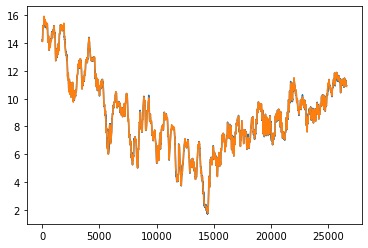

In [15]:
plt.plot(model1.predict(X_train))
plt.plot(y_train)

52/52 [==============================] - 0s 1ms/step


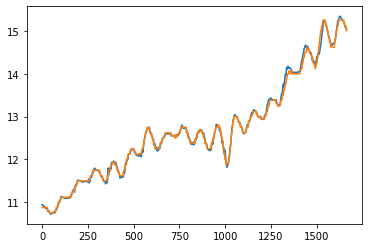

In [16]:
plt.plot(model1.predict(X_val))
plt.plot(y_val)

156/156 [==============================] - 0s 1ms/step


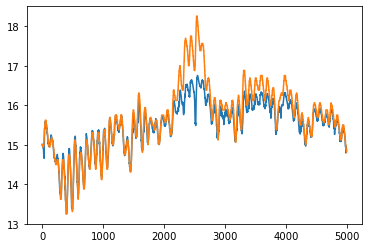

In [17]:
plt.plot(model1.predict(X_test))
plt.plot(y_test)

32/32 [==============================] - 0s 1ms/step


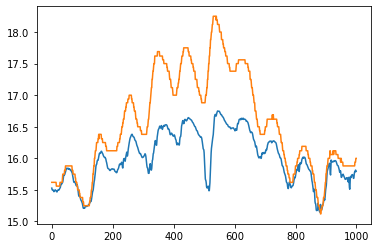

In [18]:
plt.plot(model1.predict(X_test[2000:3000]))
plt.plot(y_test[2000:3000])

31/31 [==============================] - 0s 1ms/step


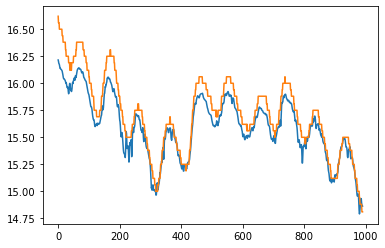

In [19]:
plt.plot(model1.predict(X_test[4000:5000]))
plt.plot(y_test[4000:5000])

In [20]:
plt.plot(model1.predict(X_test[5000:6000]))
plt.plot(y_test[5000:6000])

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [21]:
%%time
#flow rate
predictdf1 = predictdf.fillna(0)

# create a tag for the data to flag when the data is modeled and when the flow rate means the values dont make sense
for k in range(len(farmData) - window_size):
    if(farmData.loc[k+window_size][mySensor + ' Quality']!='Acceptable'):     
        
        X,y = df_to_X_y(predictdf1, window_size, mySensor) 
        predX = model1.predict(X[k:k+1])
        nbr = round(predX[0][0], 2)
        try:
            if(farmData.loc[k+window_size]['Flow (l/s) [Catchment ' + field + ']']>0.2 & farmData.loc[k+window_size]['Flow (l/s) [Catchment ' + field + ']'] < 1.8):
                farmData.at[k+window_size,mySensor + ' Quality'] = 'Model Data'
            else:
                farmData.at[k+window_size,mySensor + ' Quality'] = 'Flow Rate oob'
            farmData.at[k+window_size,mySensor] = nbr
            predictdf1.at[k+window_size,mySensor] = nbr
        except:
            farmData.at[k+window_size,mySensor + ' Quality'] = 'Model Data'
            farmData.at[k+window_size,mySensor] = nbr
            predictdf1.at[k+window_size,mySensor] = nbr    
    
farmData.to_csv('test.csv', sep=',', encoding='utf-8',index=False)

1/1 [==============================] - 0s 15ms/step
Wall time: 5min 52s


In [28]:
%%time
#water data
predictdf1 = predictdf.fillna(0)

for k in range(len(farmData) - window_size):
    if(farmData.loc[k+window_size][mySensor + ' Quality']!='Acceptable'):     
        
        X,y = df_to_X_y(predictdf1, window_size, mySensor) 
        predX = model1.predict(X[k:k+1])
        nbr = round(predX[0][0], 2)
        if(nbr>0.2 & nbr < 1.8):
            farmData.at[k+window_size,mySensor + ' Quality'] = 'Model Data'
        else:
            farmData.at[k+window_size,mySensor + ' Quality'] = 'Flow Rate oob'
        farmData.at[k+window_size,mySensor] = nbr
        predictdf1.at[k+window_size,mySensor] = nbr
    
    

farmData.to_csv('test.csv', sep=',', encoding='utf-8',index=False)

1/1 [==============================] - 0s 15ms/step


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [24]:
farmData.to_csv('test.csv', sep=',', encoding='utf-8',index=False)

In [10]:
#visualize
visData = pd.read_csv('test.csv')

sensors = [(mySensor + " Quality")]
for column in visData.columns:
    if column.endswith("]"):
        sensors.append(column)
VRIA = '{"title": "Field '+ field + '" ,"data":{ "values": [\n'

for k in range(len(visData)):
    value =  '{\n'
    for l in range(len(sensors)):
        if l==0:
            value += ('"' +sensors[l] + '": "' + str(visData.loc[k,sensors[l]]) + '",\n')
        elif (l+1) < (len(sensors)):
            value += ('"' +sensors[l] + '":' + str(visData.loc[k,sensors[l]]) + ',\n')
        else:
            value += ('"' +sensors[l] + '":' + str(visData.loc[k,sensors[l]])+ '\n')
    if (k+1) < (len(visData)):
        value +=  '},\n'
    else:
        value +=  '}\n'
    if ":nan" not in value:
        VRIA += value
        
VRIA+=("""   ] 
  },
  "mark": {
  "type":"point",
  "tooltip":true
  },
  "encoding": {
    "x": {
      "field": \"""" + sensors[1] + """\",
      "type": "quantitative",
      "axis":{
      "filter":true
      },
      "scale":{
      "zero":false
      }
    },
    "y": {
      "field": \"""" + sensors[2] + """\",
      "type": "quantitative",
      "axis":{
      "filter":true
      },
      "scale":{
      "zero":false
      }
    },
    "z": {
      "field": \"""" + sensors[3] + """\",
      "type": "quantitative",
      "axis":{
      "filter":true
      },
      "scale":{
      "zero":false
      }
    },
    "color": {
      "field": \"""" + sensors[0] + """\",
      "type": "nominal"
  }},
  "width": 0.5,
  "height": 0.5,
  "depth": 0.5,
  "x": 0.25,
  "y": 0.2,
  "z": -0.25
}""")



In [ ]:
VRIA.append("""   ] 
  },
  "mark": "point",
  "encoding": {
    "x": {
      "field": " Precipitation (mm) [Site],
      "type": "quantitative"
    },
    "y": {
      "field": Air Temperature (oC) [Site],
      "type": "quantitative"
    },
    "z": {
      "field": Soil Temperature @ 15cm Depth (oC) [Catchment 12],
      "type": "quantitative"
    },
    "color": {
      "field": + SENSORQUALITY+,
      "type": "nominal"
    }
  },
  "width": 0.5,
  "height": 0.5,
  "depth": 0.5,
  "x": 0.25,
  "y": 0.2,
  "z": -0.25
}""")
#for i in range(len(sensors)):
    #print(i)


In [12]:
text_file = open("Output.txt", "w")

text_file.write(VRIA)

text_file.close()